# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 

## Fecha de entrega

22/06/2021

## Integrantes

* <Agustin, Sosa Lütcher>
* <Valentin, Gaglione>
* <Leandro, Di Meo>

## Librerias

In [1]:
import numpy as np
import soundfile as sf
import pandas as pd
from scipy import signal
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import sounddevice as sd
import simpleaudio as sa
from IPython.display import Image
import soundfile as sf
import scipy



#Para funcion carga de archivos.
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

## Funciones Graficadoras

In [6]:
def graficador(ys,nombre,ti,ejex,ejey):
    """
    Permite plotear funciones
    Parámetros de entrada:
     ys es la función, nombre es el nombre del grafico, ti es la coordenada independiente,
     ejex nombre del eje X y ejey nombre del eje Y.
    Return: Gráfica de la función de entrada con posibilidad de nombrar los ejes y darle un título
    """
    fs = 44100
    x = (np.linspace (0, ti, fs*ti,False))
    # plot
    plt.plot(x,ys, 'r')
    plt.title(nombre)
    plt.xlabel(ejex) 
    plt.ylabel(ejey)
    plt.show()

## Parametros

In [52]:
T = int(input("Ingrese el tiempo de reproducción:"))
fs = int(input("Ingrese la frecuencia de muestreo:"))
f1 = float(input("Ingrese frecuencia inferior:" ))
f2 = float(input("Ingrese frecuencia superior:" ))
t = np.linspace(0., T, fs*T, False)

Ingrese el tiempo de reproducción: 5
Ingrese la frecuencia de muestreo: 44100
Ingrese frecuencia inferior: 20
Ingrese frecuencia superior: 20000


## Ruido Rosa

In [7]:
def ruidoRosa_voss(ti, fs=44100, ncols=16):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney(https://www.dsprelated.com/showabstract/3933.php).
    
    .. Nota:: si 'ruidoRosa.wav' existe, este será sobreescrito
    
    Parametros
    ----------
    ti : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    rcols: int
        Determina el número de fuentes a aleatorias a agregar.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz. 
    
    returns: NumPy array
             Genera un `.wav` desde un numpy array de ti segundos con ruido rosa a una 
    frecuencia de muestreo de 44100 Hz
    """
    nrows = ti*fs
    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # el numero total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    
    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)
    
    ## Centrado de el array en 0
    total = total - total.mean()
    
    ## Normalizado
    valor_max = max(abs(max(total)),abs(min(total)))
    total = total / valor_max
    
    filename = '../ruidoRosa.wav' #Nombre del archivo
    sd.wait()  #Esperar a que finalice la grabación
    write(filename, fs, total) #grabación

    return total

In [8]:
r_rosa = ruidoRosa_voss(T, fs, ncols=16)

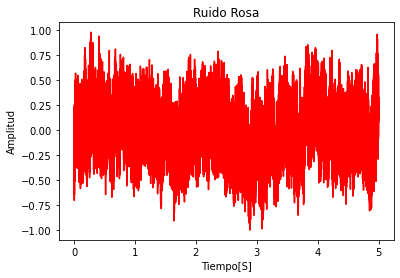

In [9]:
graficador(r_rosa,'Ruido Rosa',T,'Tiempo[S]','Amplitud')

## Sinesweep

In [3]:
def sinesweep (f1, f2, T,t) : #Función sinesweep
    """
    La función sinesweep genera un barrido en frecuencias que decae 3dB/octava.
       Parametros de entrada: f1:Frecuencia incial del barrido.Formato Float.
                              f2:Frecuencia final del barrido.Formato Float.
                              T: Tiempo de duración.Formato Int.
                              t:variable temporal.Formato Array.
       Parametro de salida: f: representa la función del barrido.
       También exporta audio formato .wav de duración T segundos y frecuencia de muestreo fs, si el mismo ya existe, será sobreescrito. 
       Dicha función utiliza recursos de la librería numpy, importando la misma como import numpy as np.
    """
    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2
    R = np.log(w2 / w1)
    L = T / R
    K = (T*w1)/R
    f = np.sin(K*(np.exp(t/L) - 1))
    filename = '../sinesweep.wav' #Nombre del archivo
    sd.wait()  #Esperar a que finalice la grabación
    write(filename, fs, f) #grabación
    return f

In [4]:
sinesweep_audio = sinesweep(f1,f2,T,t)

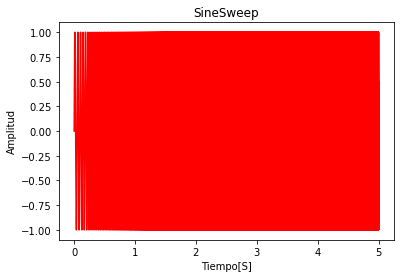

In [8]:
graficador(sinesweep_audio,'SineSweep',T,'Tiempo[S]','Amplitud')

## Filtro Inverso

In [9]:
def filtroinverso (f1,f2,T,t): #Función filtro
    """
    La función filtroinverso genera un filtro que aumenta 3dB/octava. 
       Parametros de entrada: f1:Frecuencia incial del barrido.Formato Float
                              f2:Frecuencia final del barrido.Formato Float
                              T: Tiempo de duración.Formato Int
                              t:variable temporal.Formato Array
       Parametro de salida: FI: representa la función de filtro inverso.
       También exporta audio formato .wav de duración T segundos y frecuencia de muestreo fs, si el mismo ya existe, será sobreescrito. 
       Dicha función utiliza recursos de la librería numpy, importando la misma como import numpy as np.
    """
    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2
    R = np.log(w2 / w1)
    L = T / R
    K = (T*w1)/R
    W = (K/L)*np.exp(t/L)
    M = w1/(2*np.pi*W)
    FI = M*sinesweep(f1,f2,T,t[::-1])
    filename = '../filtroinverso.wav' #Nombre del archivo
    sd.wait()  #Esperar a que finalice la grabación
    write(filename, fs, FI) #grabación
    return FI

In [10]:
filtro_inv = filtroinverso(f1,f2,T,t)

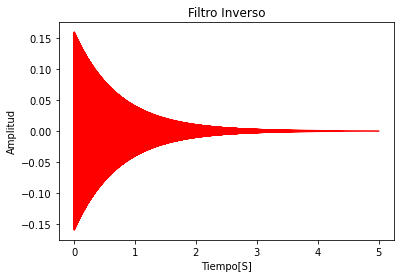

In [11]:
graficador(filtro_inv,'Filtro Inverso',T,'Tiempo[S]','Amplitud')

## Función de carga de archivos

In [12]:
def cargar_audio(paths):
    """
    In: Array con path de los archivos de audio.

    Out: Array con informacion de los archivos de audio, en sendos diccionarios.
    Los diccionarios tienen las keys las keys:
      

    Data: Contiene la codificacion de pulso modulado
    Bitdepth: Dtype del array data de audio.
    Subtype: Contiene la informacion de formato extraida con la libreria soundfile
    Duracion: La duracion en segundos del archivo de audio
      Samplerate: Frecuencia de sampleo obtenida con la libreria soundfile
      Nombre: El del objeto del cual se tomo la informacion. Se probo en wav.
      t: Linspace de largo igual a Duracion, con pasos de 1/(frecuencia de sampleo)

      Los diccionarios se crean en el orden que tenian los archivos en el array in. Se puede llamar el directorio de cada archivo como cargar_audio(pathfiles)[indice del archivo dentro del array]
    """
    audiodiccs=[]
    for path in paths:
        archivo=sf.SoundFile(path)
        data , fs = sf.read(path)
        subtype= "MAT5" if "DOUBLE"==archivo.subtype else "WAVE"
        frames=archivo.frames
        bitdepth=data.dtype
        audiodicc={"Nombre":None,"Samplerate":None, "Duracion":None,"Bitdepth":None,"Data":None, "t":None, "Subtype":None}
        audiodicc.update({"Nombre":path,"Samplerate":fs,"Bitdepth":bitdepth,"Duracion":frames/fs,"Subtype":subtype,"Data":data, "t":np.linspace(0,frames/fs,frames)})
        archivo.close()
        audiodiccs.append(audiodicc)
      
    return audiodiccs


Botón selector

In [13]:
files = []
def select_files(b,files=files):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    files.append(filedialog.askopenfilename()) # List of selected files will be set button's file attribute.
    print(files) # Print the list of files selected.

fileselect = Button(description="Seleccione el archivo")
fileselect.on_click(select_files)

display(fileselect)
files

Button(description='Seleccione el archivo', style=ButtonStyle())

[]

## Función grabado y reproducción

In [14]:
def recplay (file , duracion,canales): 
    """ 
    Función para grabar y reproducir Audios
    Graba en formato.wav
    Parametros de entrada:
    file es el archivo de audio a reproducir
    out es el nombre de la grabacion
    duracion es el tiempo de grabacion.
    Return Audio grabado en .wav con "duracion" segundos y frecuencia de muestreo fs.
    """                                 
    fs, data = read(file)
    sd.play(data,fsr)
    sd.wait() 
    grabacion = sd.rec(int(duracion * fs),fs,canales)
    status=sd.wait()
    return grabacion

In [15]:
def plays (file):
    """
    Función para reproducción de archivos
    Parametros de entrada:
    File es el archivo a reproducir
    A la salida obtengo la reproducción, hasta el final, del archivo.
    Utiliza librerias de sounddevice
    """
    audio2 = file * (2**15 - 1) / np.max(np.abs(file)) #Defino y reproduzco la función
    audio2 = audio2.astype(np.int16)
    play_obj = sa.play_buffer(audio2, 1, 2, 44100)
    play_obj.wait_done()


In [17]:
plays(filtro_inv)

## Sintesis Respuesta al Impulso

In [85]:
def sintetizacion_ri(rt,amps,freqs,fs): 
    """
    Sintetiza una respuesta al impulso
    Parámetros de entrada:
        rt: array de tiempo de reverberacion por banda de frecuencias
        amps: moduladores de amplitud por 
        freqs: array con frecuencias utilizadas en Hz
    Salida:
        Array sintesis de respuesta al impulso y audio 
    Utiliza bibioteca de numpy
    """
    duracion=3*int(np.ceil(max(rt)))
    risub=np.zeros(duracion*fs,) #respuesta al impulso
    for i in np.arange(len(rt)):

        ri=lambda t: amps[i]*np.exp(t*rt[i]/np.log(10**-3))*np.cos(2*np.pi*freqs[i]*t)
        ritot=risub+ri(np.linspace(0,duracion,duracion*fs))
    filename = '../sinte_ri.wav' #Nombre del archivo
    sd.wait()  #Esperar a que finalice la grabación
    write(filename, fs, ritot) #grabación   
    return ritot

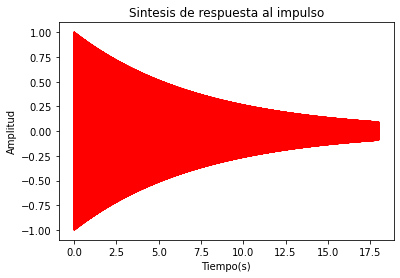

In [88]:
freqs = [31.25,62.5,125,250,500,1000,2000,4000,8000,16000]
rt= [5.68,4.41,3.86,2.86,2.59,2.61,2.47,2.02,1.32,0.92] #Obtenido de 1st_baptist_nashville_balcony"
amps = np.ones(10)
sinte=sintetizacion_ri(rt,amps,freqs,fs)
T=int(3*np.ceil(max(rt)))
graficador(sinte,"Sintesis de respuesta al impulso",T,"Tiempo(s)","Amplitud")

## Función de obtención de la respuesta al impulso

In [53]:
def resp_imp (x, y):
    '''Función de obtención de la respuesta al impulso de un recinto
       Parametros de entrada:
       X:Impulso o excitación
       Y:Captación del impulso con la respuesta del recinto
       Mediante la transformada rapida de fourier de la biblioteca Scipy, 
       Return: Respuesta al impulso de la sala'''

    Y = scipy.fft(y)
    X = scipy.fft(x)
    H = Y/X
    h = scipy.ifft(H)
    return h


In [54]:
resp_impulso = resp_imp(filtro_inv,sinesweep_audio)


<ipython-input-53-af28ed75b054>:9: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  Y = scipy.fft(y)
<ipython-input-53-af28ed75b054>:10: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  X = scipy.fft(x)
<ipython-input-53-af28ed75b054>:12: DeprecationWarning: scipy.ifft is deprecated and will be removed in SciPy 2.0.0, use scipy.fft.ifft instead
  h = scipy.ifft(H)


C:\Users\LeaDm\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


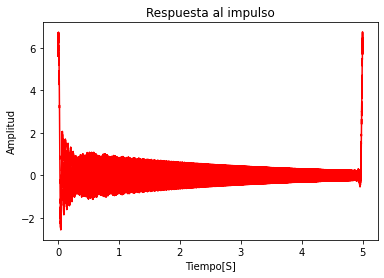

In [55]:
graficador(resp_impulso,'Respuesta al impulso',T,'Tiempo[S]','Amplitud')

## Función filtros norma IEC61260

In [46]:
def Filtro (fs,bandwidth,archivo):
    '''Filtro por octava o tercio de octava segun Norma 612600
       Parametros de entrada: 
        fs: Frecuencia de muestreo
        bandwith: Selector de octava o tercio de octava '''
    if bandwidth == 'octava': #ancho de banda de a octava 
        freqs = [31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000]
        G = 1.0/2.0
    elif bandwidth == 'tercio': #ancho de banda de a tercio de octava 
        freqs = [19.69,24.80,31.25,39.37,49.61,62.50,78.75,99.21,125,157.5,198.4,250,
                 315,396.9,500,630,793.7,1000,1260,1587,2000,2520,3175,4000,5040,6350,8000]
        G = 1.0/6.0
    factor = np.power(2,G)
    for i in range(0,len(freqs)):
        frec_central = freqs[i] #Define las diferentes frecuencias centrales para el array freqs
        fcorte_inf = frec_central/factor #Define las diferentes frecuencias de corte inferior para el array freqs
        fcorte_sup = frec_central*factor #Define las diferentes frecuencias de corte superior para el array freqs
        sos = signal.iirfilter(8, [fcorte_inf,fcorte_sup],
                            rs=60, btype='band', analog=False,
                            ftype='butter', fs=fs, output='sos')
        filt = signal.sosfilt(sos, archivo)
        filename[i] = '../filtrado[i].wav' #Nombre del archivo
        #sd.wait()  #Esperar a que finalice la grabación
        write(filename, fs, filt) #grabación 
        plt.plot(t,filt)
    #filename = '../filtrado.wav' #Nombre del archivo
    #sd.wait()  #Esperar a que finalice la grabación
    #write(filename, fs, filt) #grabación 

In [45]:
filtro = Filtro(fs,'octava',resp_impulso)

NameError: name 'filename' is not defined

## Función conversión a escala logarítmica normalizada

In [56]:
def convlognormal(F):
    """
    Conversion a escala logaritmica normalizada
    Parámetros de entrada:
    F: Función a escalar
    Salida: Función normalizada y a escala logaritmica
    Utiliza librería Numpy.
    """
    ampmax=np.max(F)
    Fln=20*np.log10(F/ampmax)
    return Fln

C:\Users\LeaDm\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


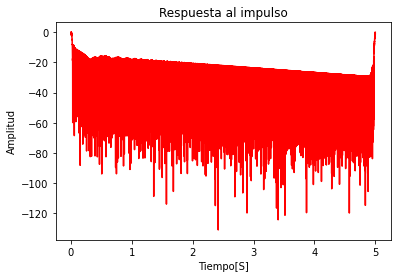

In [57]:
aa = convlognormal(resp_impulso)
graficador(aa,'Respuesta al impulso',T,'Tiempo[S]','Amplitud')

## Transformada de Hilbert

In [83]:
def transf_hilbert (S):
    """Realiza la transformada de Hilbert para una función de entrada.
    Parámetros de entrada
    S: Función a aplicar la transformada.
    Salida: Transformada de Hilbert"""
    n = 1/(np.pi*t)
    Hilb = np.convolve(S,n,mode = 'same')
    return Hilb # ir por scipy 

<ipython-input-83-89189eced265>:6: RuntimeWarning: divide by zero encountered in true_divide
  n = 1/(np.pi*t)
C:\Users\LeaDm\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


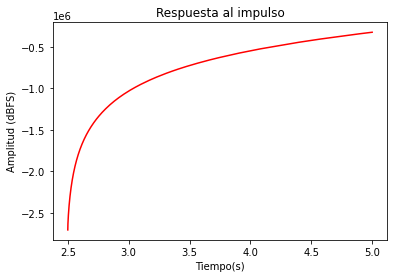

In [84]:
ss = transf_hilbert(aa)
graficador(ss,"Respuesta al impulso",T,"Tiempo(s)", "Amplitud (dBFS)")

## Regresión Lineal

In [ ]:
def reglin(data,t)
    """
    Aplica la fórmula de regresión lineal para obtener la recta que mejor se aproxima a la respuesta al impulso suavizada.
    Parámetros de entrada:
    data : Función de entrada
    t: tiempo
    Salida: Regresión lineal
    """

    y=transpose(data);        #vector valor de muestra
    x=t;                      #vector muestras
    n=len(t);                 #cantidad de muestras

    c1=sum(x.^2);
    c2=sum(y);
    c3=sum(x.*y);
    c4=sum(x);

    ord = (c1*c2-c3*c4)/(n*c1-c4^2);
    pend = (n*c3-c4*c2)/(n*c1-c4^2);
    recta=[pend,ord];
    y = pend*x + ord 
    return y

## Función de Schroeder